# Test the readout emulation library with a ROOT file

I've defined a minimal readout emulator library, in the CYGNUS code repository. Let's see if it works with a real Geant4 simulation!

In [1]:
%pylab
from ROOT import TFile, TTree
import pandas as pd
from simpleparamaterisation import TPCevt as TPC

Using matplotlib backend: <object object at 0x7fd7129ff2f0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.28/00


In [5]:
f = TFile.Open("../archive/simOut_28796KShell.root")

In [6]:
print(type(f.data))

<class cppyy.gbl.TTree at 0x557022a99f30>


In [7]:
maxZ = 0
minZ = 0
for evt in f.data:
    if evt.z0 > maxZ:
        maxZ = evt.z0
    if evt.z0 < minZ:
        minZ = evt.z0

In [9]:
print(minZ, maxZ)

-149.99929931251035 149.9999451472666


The TPC is 300 mm high, and the origin in the simulation is in the centre. For the code to work, I'll need to shift the co-ordinates by 15 cm because the readout plane is meant to be z=0

# First pass -- single event

In [10]:
%%timeit
saveevt = 1
#Read first event
for i, evt in enumerate(f.data):
    PrimaryEvt = pd.DataFrame({'x': np.asarray(evt.x)/10 + 15, 'y': np.asarray(evt.y)/10 + 15, 
                            'z': np.asarray(evt.z)/10 + 15, 
                            'Edep': np.asarray(evt.edep)*1000})
    InitVertex = (evt.x0/10 + 15, evt.y0/10 + 15, evt.z0/10 + 15)
    InitMomDir = (evt.px0, evt.py0, evt.pz0)
    InitEn = evt.E0*1000
    if i == saveevt:
        break

23.2 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
saveevt = 1
#Read first event
for i, evt in enumerate(f.data):
    PrimaryEvt = pd.DataFrame({'x': np.asarray(evt.x)/10 + 15, 'y': np.asarray(evt.y)/10 + 15, 
                            'z': np.asarray(evt.z)/10 + 15, 
                            'Edep': np.asarray(evt.edep)*1000})
    InitVertex = (evt.x0/10 + 15, evt.y0/10 + 15, evt.z0/10 + 15)
    InitMomDir = (evt.px0, evt.py0, evt.pz0)
    InitEn = evt.E0*1000
    if i == saveevt:
        break

Let's look at what the dataframe looks like...

In [12]:
PrimaryEvt

,x,y,z,Edep
0,23.962208,26.851793,26.814949,0.043670
1,23.962406,26.852028,26.814955,0.083792
2,23.962366,26.852158,26.814971,0.136588
3,23.962163,26.851833,26.814910,0.049380
4,23.961392,26.850024,26.815096,0.021973
5,23.957640,26.848118,26.816367,0.665817
6,23.956821,26.845949,26.814549,0.376015
7,23.957319,26.844613,26.812828,0.433897
8,23.957131,26.846090,26.812778,0.016025
9,23.957751,26.844945,26.813446,1.052442


In [13]:
print(((InitVertex[0]-PrimaryEvt['x'][0])**2 + (InitVertex[1]-PrimaryEvt['y'][0])**2 + 
      (InitVertex[2] - PrimaryEvt['z'][0])**2)**0.5)

2.9864510505681103


In [14]:
InitVertex

(24.005541066864634, 26.63050592598521, 23.83702270135447)

In [15]:
PrimaryEvt.Edep.sum()

2.8796

In [16]:
InitEn

2.8796

In [17]:
InitMomDir

(-0.014509977900073877, 0.07409695062296387, 0.997145477074292)

In [18]:
#Define the detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

In [19]:
TPC.generate_carriers(PrimaryEvt, det)

In [20]:
PrimaryEvt

,x,y,z,Edep,NIP
0,23.962208,26.851793,26.814949,0.043670,3
1,23.962406,26.852028,26.814955,0.083792,5
2,23.962366,26.852158,26.814971,0.136588,5
3,23.962163,26.851833,26.814910,0.049380,0
4,23.961392,26.850024,26.815096,0.021973,1
5,23.957640,26.848118,26.816367,0.665817,29
6,23.956821,26.845949,26.814549,0.376015,21
7,23.957319,26.844613,26.812828,0.433897,17
8,23.957131,26.846090,26.812778,0.016025,0
9,23.957751,26.844945,26.813446,1.052442,38


In [21]:
DriftedEvt = TPC.drift_carriers(PrimaryEvt, det)

In [22]:
ReadoutEvt = TPC.gain_and_readout(DriftedEvt, det, nsigma_extend=5)

In [23]:
DriftedEvt

,idx_PrimaryEvt,x,y,dt
0,0,23.828451,26.845441,0.157225
1,0,23.864591,27.033843,0.158035
2,0,24.152682,26.947947,0.157565
3,1,24.045478,26.769744,0.158093
4,1,23.80996,26.769521,0.157247
...,...,...,...,...
114,9,23.86254,26.955363,0.158146
115,9,24.177133,26.813622,0.157409
116,9,23.905216,26.930801,0.157039
117,9,24.108586,26.925704,0.157645


In [24]:
print(PrimaryEvt.NIP.sum())

119


In [25]:
ReadoutEvt

,x,y,dt,Nel
0,23.6,26.5,0.157,96.241722
1,23.6,26.5,0.158,430.513781
2,23.6,26.5,0.159,59.994444
3,23.6,26.6,0.157,1759.319923
4,23.6,26.6,0.158,2686.909882
...,...,...,...,...
268,24.4,27.1,0.157,18.345268
269,24.4,27.1,0.158,316.490167
270,24.4,27.1,0.159,324.494279
271,24.4,27.2,0.158,29.808231


In [26]:
%matplotlib inline

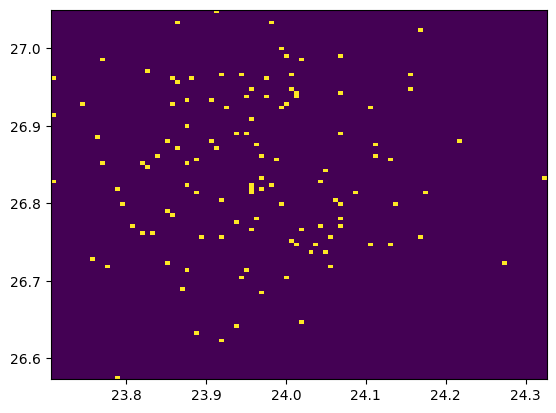

In [27]:
plt.hist2d(DriftedEvt['x'], DriftedEvt['y'], range=((min(DriftedEvt['x']),max(DriftedEvt['x'])),
                                                    (min(DriftedEvt['y']),max(DriftedEvt['y']))), bins=(100,100));

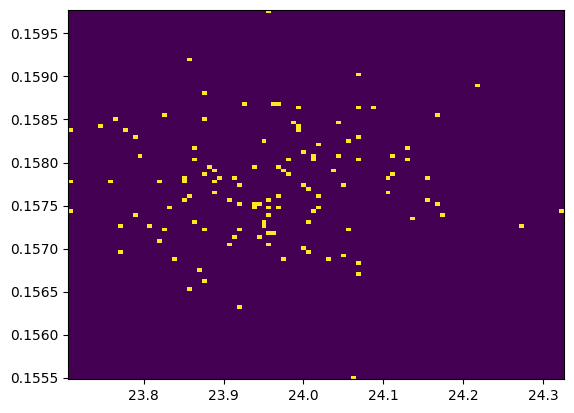

In [28]:
plt.hist2d(DriftedEvt['x'], DriftedEvt['dt'], range=((min(DriftedEvt['x']),max(DriftedEvt['x'])),
                                                    (min(DriftedEvt['dt']),max(DriftedEvt['dt']))), bins=(100,100));

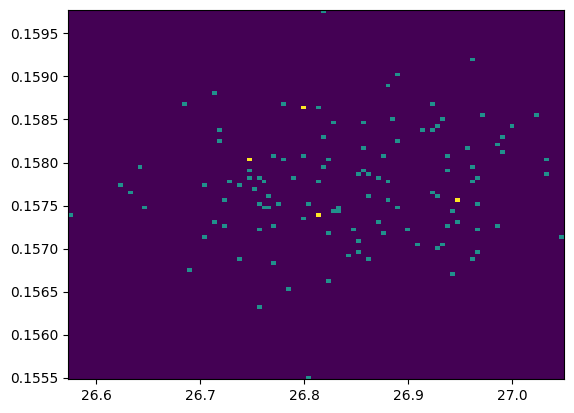

In [29]:
plt.hist2d(DriftedEvt['y'], DriftedEvt['dt'], range=((min(DriftedEvt['y']),max(DriftedEvt['y'])),
                                                    (min(DriftedEvt['dt']),max(DriftedEvt['dt']))), bins=(100,100));

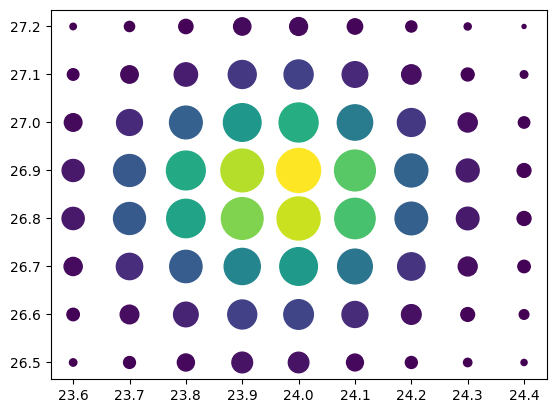

In [30]:
projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*1000)

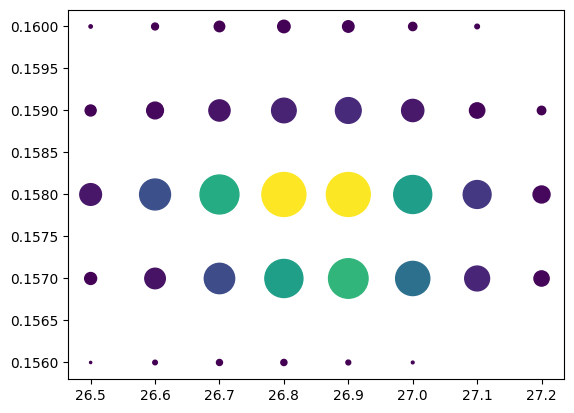

In [31]:
projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*1000)

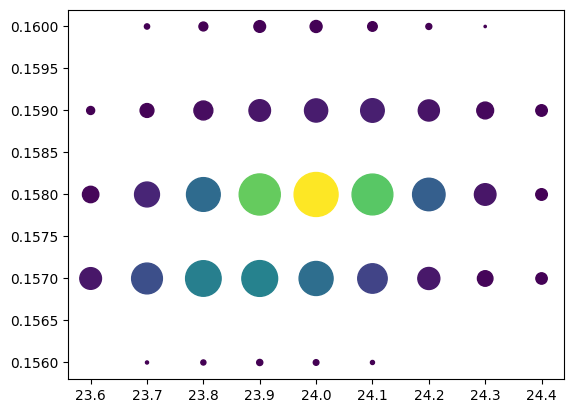

In [32]:
projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*1000)

In [36]:
# This is necessary to set up 3D rotatable plots
%matplotlib widget 

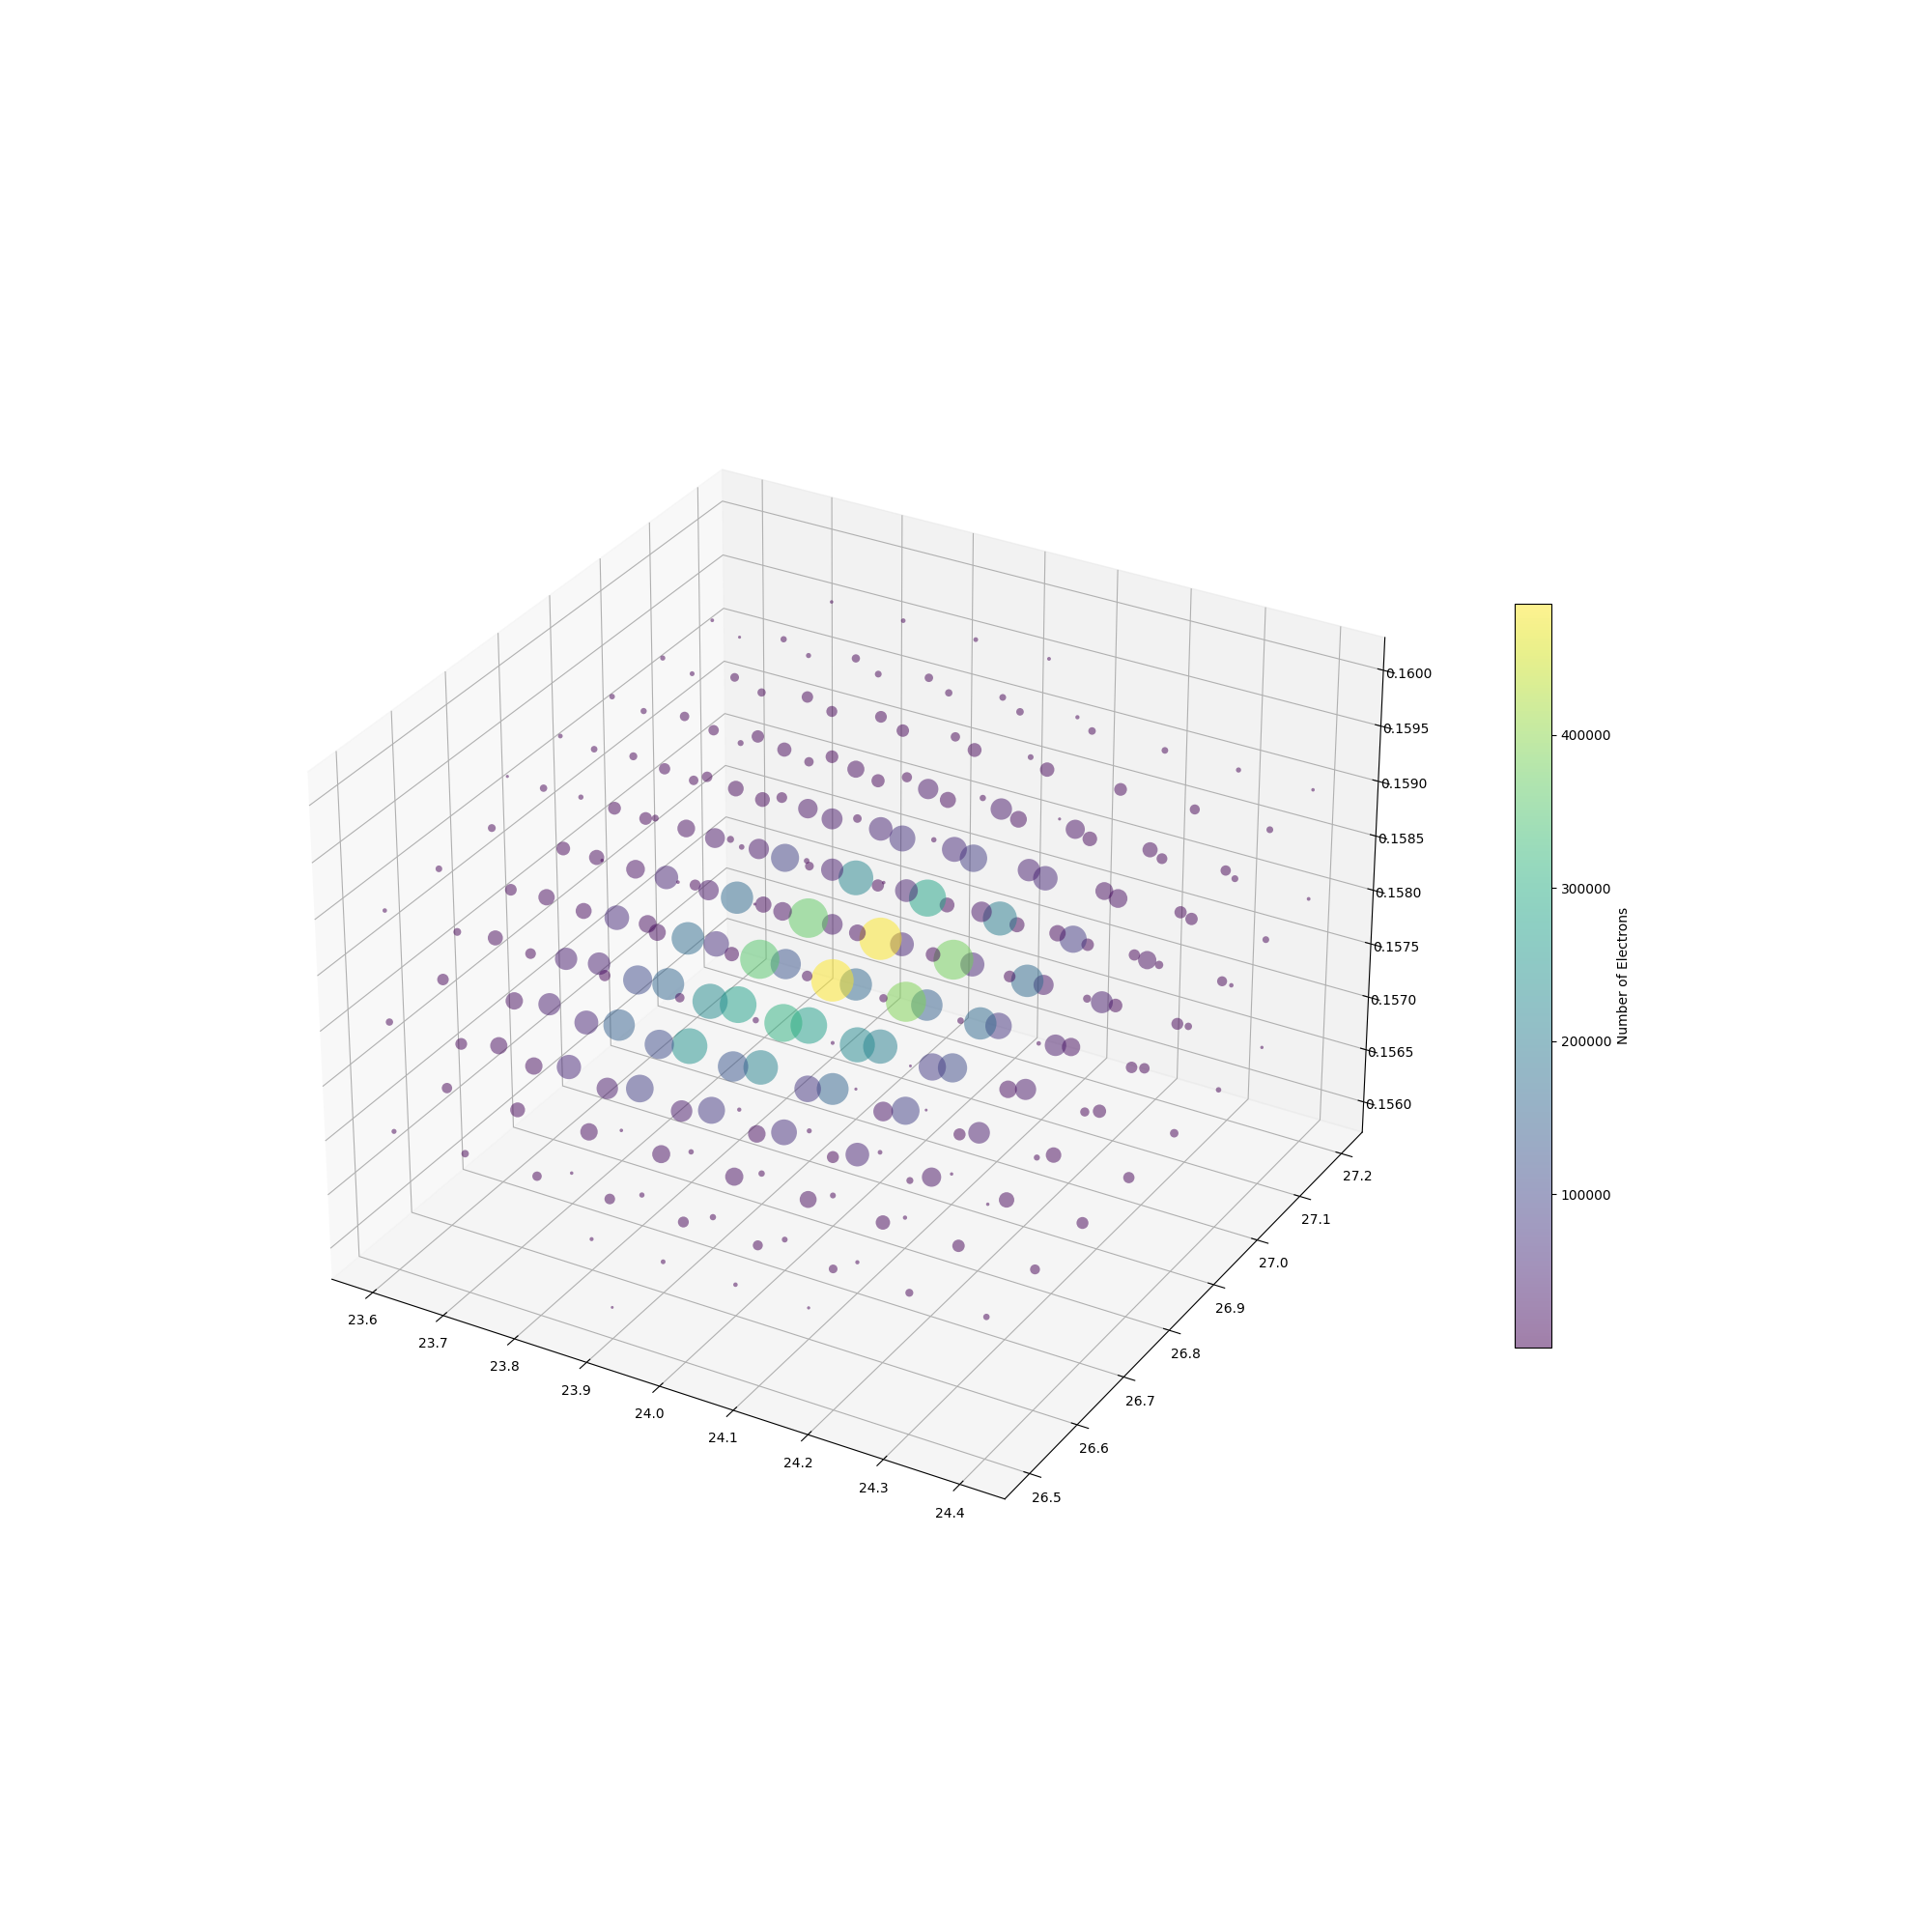

In [38]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection="3d")

sc = ax.scatter(ReadoutEvt.x, ReadoutEvt.y, ReadoutEvt.dt, 
           c=ReadoutEvt.Nel, s=((ReadoutEvt.Nel/np.max(ReadoutEvt.Nel))**0.5)*1000, alpha=0.5, lw=0)#, marker='.')
cb = plt.colorbar(sc, shrink=0.5, drawedges=False, spacing='proportional', label='Number of Electrons')
cb.solids.set_linewidth(3)
plt.show()

# Second pass: speed test

In [30]:
#Define the detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")#, Edrift=100, samplerate=0.0001)

In [31]:
evt.x0

90.05541066864635

In [32]:
pd.DataFrame({'x':[evt.x0], 'y':[evt.y0], 'z':[evt.z0], 'Edep':[-1], 'NIP':[1]})

,x,y,z,Edep,NIP
0,90.055411,116.305059,88.370227,-1,1


In [33]:
pd.concat([pd.DataFrame({'x':[evt.x0], 'y':[evt.y0], 'z':[evt.z0], 'Edep':[-1], 'NIP':[1]}),PrimaryEvt], axis=0)

,x,y,z,Edep,NIP
0,90.055411,116.305059,88.370227,-1.000000,1
0,23.962208,26.851793,26.814949,0.043670,2
1,23.962406,26.852028,26.814955,0.083792,4
2,23.962366,26.852158,26.814971,0.136588,6
3,23.962163,26.851833,26.814910,0.049380,1
4,23.961392,26.850024,26.815096,0.021973,1
5,23.957640,26.848118,26.816367,0.665817,30
6,23.956821,26.845949,26.814549,0.376015,11
7,23.957319,26.844613,26.812828,0.433897,15
8,23.957131,26.846090,26.812778,0.016025,0


In [34]:
PrimaryEvt.NIP.sum()

109

In [35]:
PrimaryEvt

,x,y,z,Edep,NIP
0,23.962208,26.851793,26.814949,0.043670,2
1,23.962406,26.852028,26.814955,0.083792,4
2,23.962366,26.852158,26.814971,0.136588,6
3,23.962163,26.851833,26.814910,0.049380,1
4,23.961392,26.850024,26.815096,0.021973,1
5,23.957640,26.848118,26.816367,0.665817,30
6,23.956821,26.845949,26.814549,0.376015,11
7,23.957319,26.844613,26.812828,0.433897,15
8,23.957131,26.846090,26.812778,0.016025,0
9,23.957751,26.844945,26.813446,1.052442,39


In [36]:
PrimaryEvt.NIP.sum()

109

In [37]:
DriftedEvt.head()

,idx_PrimaryEvt,x,y,dt
0,0,23.897602,26.762624,0.158083
1,0,24.007695,27.061193,0.157976
2,1,24.144192,26.766748,0.158076
3,1,24.075419,27.045291,0.158295
4,1,23.921358,26.965587,0.156977


In [38]:
pd.DataFrame(columns=['idx_PrimaryEvt', 'x', 'y', 'dt'], index=np.arange(-1,121,1))

,idx_PrimaryEvt,x,y,dt
-1,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
...,...,...,...,...
116,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,NaN


In [39]:
Ndrifted = int(PrimaryEvt['NIP'].sum())
print(Ndrifted)

109


In [40]:
np.arange(PrimaryEvt.index[0],Ndrifted+PrimaryEvt.index[0],1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108])

In [41]:
DriftedEvt = pd.DataFrame(columns=['idx_PrimaryEvt', 'x', 'y', 'dt'], 
                          index=np.arange(PrimaryEvt.index[0],Ndrifted+PrimaryEvt.index[0],1))
print(DriftedEvt)

    idx_PrimaryEvt    x    y   dt
0              NaN  NaN  NaN  NaN
1              NaN  NaN  NaN  NaN
2              NaN  NaN  NaN  NaN
3              NaN  NaN  NaN  NaN
4              NaN  NaN  NaN  NaN
..             ...  ...  ...  ...
104            NaN  NaN  NaN  NaN
105            NaN  NaN  NaN  NaN
106            NaN  NaN  NaN  NaN
107            NaN  NaN  NaN  NaN
108            NaN  NaN  NaN  NaN

[109 rows x 4 columns]


In [42]:
DriftedEvt['idx_PrimaryEvt'].loc[-1:0]

0    NaN
Name: idx_PrimaryEvt, dtype: object

In [43]:
DriftedEvt['idx_PrimaryEvt'][-1:0] = -1

In [44]:
DriftedEvt

,idx_PrimaryEvt,x,y,dt
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
104,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN


In [45]:
int(PrimaryEvt['NIP'][1])

4

In [46]:
PrimaryEvt

,x,y,z,Edep,NIP
0,23.962208,26.851793,26.814949,0.043670,2
1,23.962406,26.852028,26.814955,0.083792,4
2,23.962366,26.852158,26.814971,0.136588,6
3,23.962163,26.851833,26.814910,0.049380,1
4,23.961392,26.850024,26.815096,0.021973,1
5,23.957640,26.848118,26.816367,0.665817,30
6,23.956821,26.845949,26.814549,0.376015,11
7,23.957319,26.844613,26.812828,0.433897,15
8,23.957131,26.846090,26.812778,0.016025,0
9,23.957751,26.844945,26.813446,1.052442,39


In [47]:
PrimaryEvt.NIP.sum()

109

In [48]:
DriftedEvt2 = pd.DataFrame(1. Write a library to allow the code to be called externally. I might be able to encapsulate things within a class, but maybe I don't want to do that to give the person calling the code more flexibility? This needs to be a priority, since running externally will allow studies to start (and it'll be cle1. Write a library to allow the code to be called externally. I might be able to encapsulate things within a class, but maybe I don't want to do that to give the person calling the code more flexibility? This needs to be a priority, since running externally will allow studies to start (and it'll be clear whether the code needs to be sped up).ar whether the code needs to be sped up).columns=['idx_PrimaryEvt', 'x', 'y', 'dt'],
                           index=np.arange(PrimaryEvt.index[0],PrimaryEvt.NIP.sum()+PrimaryEvt.index[0],1))



SyntaxError: unmatched ')' (732697692.py, line 1)

In [ ]:
counter = int(PrimaryEvt.index[0])
for i in PrimaryEvt.index:
    numtodrift = int(PrimaryEvt['NIP'][i])
    thisz = PrimaryEvt['z'][i]
    DriftedEvt2['idx_PrimaryEvt'].loc[counter:(counter+numtodrift-offset)-1] = i
    DriftedEvt2['x'].loc[counter:(counter+numtodrift)-1] = PrimaryEvt['x'][i] + np.random.normal(loc=0,
                                                            scale=TPC.driftsigma_trans(thisz, det),
                                                            size=numtodrift)
    DriftedEvt2['y'].loc[counter:(counter+numtodrift)-1] = PrimaryEvt['y'][i] + np.random.normal(loc=0,
                                                            scale=TPC.driftsigma_trans(thisz, det),
                                                            size=numtodrift)
    DriftedEvt2['dt'].loc[counter:(counter+numtodrift)-1] = (thisz + np.random.normal(loc=0,
                                                            scale=TPC.driftsigma_long(thisz, det),
                                                            size=numtodrift))/det.vdrift
    counter += numtodrift


NameError: name 'offset' is not defined

In [ ]:
PrimaryEvt

,x,y,z,Edep,NIP
-1,-138.117056,34.845512,80.823438,-1.0,1.0


In [ ]:
DriftedEvt2

,idx_PrimaryEvt,x,y,dt
-1.0,-1,-137.958379,34.617993,0.47661


In [ ]:
DriftedEvt2['x'].loc[counter:(counter+numtodrift)-1]

-1.0   -138.033902
Name: x, dtype: float64

In [ ]:
np.random.normal(loc=0,scale=TPC.driftsigma_trans(thisz, det),size=numtodrift)

array([-0.15195453])

In [ ]:
counter

-1

In [ ]:
DriftedEvt2

,idx_PrimaryEvt,x,y,dt
-1.0,NaN,NaN,NaN,NaN


In [ ]:
counter = int(PrimaryEvt.index[0])

In [ ]:
counter

-1

In [ ]:
numtodrift

1

In [ ]:
DriftedEvt2.loc[-1:0-1]

,idx_PrimaryEvt,x,y,dt
-1.0,-1,NaN,NaN,NaN


In [ ]:
DriftedEvt2.loc[counter:counter+numtodrift]

,idx_PrimaryEvt,x,y,dt
-1.0,-1,NaN,NaN,NaN
0.0,-1,NaN,NaN,NaN


In [ ]:
thisz

88.3702270135447

In [ ]:
np.random.normal(loc=0, scale=TPC.driftsigma_trans(thisz, det), size=numtodrift)

array([0.18207358])

In [ ]:
DriftedEvt2.loc[counter:(counter+5 + PrimaryEvt.index[0])]

,idx_PrimaryEvt,x,y,dt
-1.0,-1,NaN,NaN,NaN
0.0,-1,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN


In [ ]:
DriftedEvt

,idx_PrimaryEvt,x,y,dt
-1,-1,-138.020588,34.908044,0.476847


In [ ]:
%%time
Nevts = 100
#Read in and process N events
PrimaryEvents = [] #TODO: convert to either multiindexed DataFrame or Xarray
DriftedEvents = []
ReadoutEvents = []
# InitVertices = np.empty(shape=(Nevts,3), dtype=np.float)
InitMomDirs = np.empty(shape=(Nevts,3), dtype=np.float)
InitEns = np.empty(Nevts, dtype=np.float)
for i, evt in enumerate(f.data):
    PrimaryEvt = pd.DataFrame({'x': np.asarray(evt.x)/10, 'y': np.asarray(evt.y)/10, 
                               'z': np.asarray(evt.z)/10 + 15, 
                               'Edep': np.asarray(evt.edep)*1000})
    TPC.generate_carriers(PrimaryEvt, det)
    #Insert the vertex with 1 ion pair on PrimaryEvt, at index = -1
    PrimaryEvt.loc[-1] = [evt.x0, evt.y0, evt.z0, -1, int(1)]
    #sort the index
    PrimaryEvt.sort_index(inplace=True)
    #print(PrimaryEvt)
    PrimaryEvents += [PrimaryEvt]
    DriftedEvt = TPC.drift_carriers(PrimaryEvt, det)
    DriftedEvents += [DriftedEvt]
    if len(DriftedEvt) == 0:
        ReadoutEvt = []
    else:
        try:
            pass
            ReadoutEvt = TPC.gain_and_readout(DriftedEvt, det, nsigma_extend=4)
        except:
            print(i)
            print(PrimaryEvt)
            print(DriftedEvt)
            raise
    #ReadoutGrids += [ReadoutGrid]
    ReadoutEvents += [ReadoutEvt]
    #InitVertices[i][0] = evt.x0/10
    #InitVertices[i][1] = evt.y0/10
    #InitVertices[i][2] = evt.z0/10 + 15
    InitMomDirs[i][0] = evt.px0
    InitMomDirs[i][1] = evt.py0
    InitMomDirs[i][2] = evt.pz0
    InitEns[i] = evt.E0*1000
    if i == Nevts-1:
        break

In [ ]:
PrimaryEvt['NIP'][-1]

1.0

OK, that's quite slow. I wonder if we can do better than that? In reality we probably only need to store the Readout information and the vertex info, and total primary Edep in the gas. The rest can be done away with via cuts.

In [ ]:
SignalCharge2 = [np.sum(item) for item in ReadoutEvents]

In [ ]:
SignalCharge = [np.sum(item) for item in ReadoutEvents]

In [ ]:
%matplotlib inline

0.5


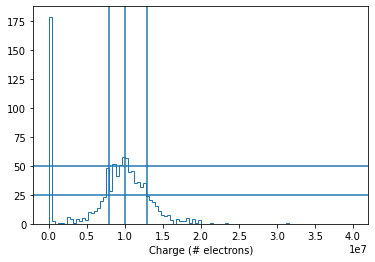

In [ ]:
plt.hist(SignalCharge2, histtype='step', bins=100, range=(0,4e7));
plt.xlabel("Charge (# electrons)")
plt.axvline(1.0e7)
plt.axhline(50)
plt.axhline(50/2)
plt.axvline(0.8e7)
plt.axvline(1.3e7)
print((1.3-0.8)/1.)

0.5803571428571427


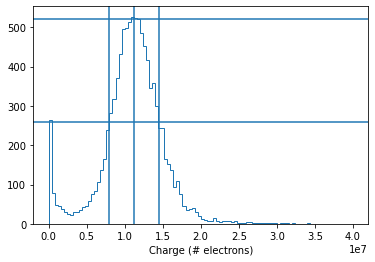

In [ ]:
plt.hist(SignalCharge, histtype='step', bins=100, range=(0,4e7));
plt.xlabel("Charge (# electrons)")
plt.axvline(1.12e7)
plt.axhline(520)
plt.axhline(520/2)
plt.axvline(0.8e7)
plt.axvline(1.45e7)
print((1.45-0.8)/1.12)

In [ ]:
themask.shape

(5, 6, 6)

In [ ]:
ReadoutGrid.shape

(3, 5, 6, 6)

In [ ]:
ReadoutEvt[themask]

array([6.84387100e+00, 4.21280492e+03, 8.34211787e+01, 2.82829456e+01,
       2.83350087e+04, 6.05361271e+02, 9.48389887e+01, 8.22979291e+04,
       1.82571295e+03, 2.89332525e+02, 1.08344255e+05, 2.46703858e+03,
       4.25788354e+02, 7.14167705e+04, 1.61555103e+03, 2.40852618e+02,
       2.60296441e+04, 5.14493513e+02, 5.05990728e+01, 4.95495424e+03,
       7.33257802e+01, 3.92692035e+00, 4.23246764e+02, 4.30043759e+00,
       7.54070075e+01, 2.22685022e+04, 5.92688411e+02, 2.90436895e+02,
       1.45858830e+05, 4.25170306e+03, 7.78233850e+02, 4.05865430e+05,
       1.26262798e+04, 2.05567637e+03, 5.00850180e+05, 1.68691218e+04,
       2.93435655e+03, 2.99674832e+05, 1.10975909e+04, 1.64965634e+03,
       9.73177711e+04, 3.60795272e+03, 3.46130446e+02, 1.70760981e+04,
       5.28867160e+02, 2.68790640e+01, 1.44989668e+03, 3.21136834e+01,
       3.07190568e+02, 4.77713470e+04, 1.83976446e+03, 1.13103340e+03,
       3.10707845e+05, 1.38232996e+04, 2.50223764e+03, 8.54920309e+05,
      

In [ ]:
ReadoutGrid[1][themask]

array([19.2, 19.2, 19.2, 19.3, 19.3, 19.3, 19.3, 19.4, 19.4, 19.4, 19.4,
       19.4, 19.5, 19.5, 19.5, 19.5, 19.5, 19.6, 19.6, 19.6, 19.6, 19.6,
       19.7, 19.7, 19.7, 19.2, 19.2, 19.2, 19.2, 19.3, 19.3, 19.3, 19.3,
       19.3, 19.4, 19.4, 19.4, 19.4, 19.4, 19.5, 19.5, 19.5, 19.5, 19.5,
       19.5, 19.6, 19.6, 19.6, 19.6, 19.6, 19.6, 19.7, 19.7, 19.7, 19.7,
       19.7, 19.7, 19.2, 19.2, 19.2, 19.2, 19.2, 19.3, 19.3, 19.3, 19.3,
       19.3, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.5, 19.5, 19.5, 19.5,
       19.5, 19.5, 19.6, 19.6, 19.6, 19.6, 19.6, 19.6, 19.7, 19.7, 19.7,
       19.7, 19.7, 19.7, 19.2, 19.2, 19.2, 19.2, 19.2, 19.3, 19.3, 19.3,
       19.3, 19.3, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.5, 19.5, 19.5,
       19.5, 19.5, 19.5, 19.6, 19.6, 19.6, 19.6, 19.6, 19.6, 19.7, 19.7,
       19.7, 19.7, 19.7, 19.7, 19.2, 19.2, 19.2, 19.2, 19.2, 19.3, 19.3,
       19.3, 19.3, 19.3, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.5, 19.5,
       19.5, 19.5, 19.5, 19.5, 19.6, 19.6, 19.6, 19

Text(0.5, 1.0, 'Y-dt projection')

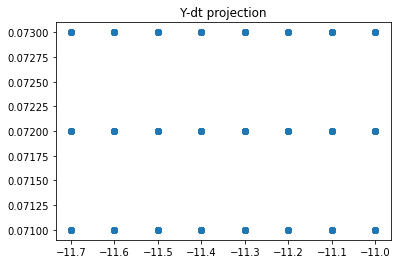

In [ ]:
# fig = plt.figure(figsize=(20,20))
# ax = plt.axes(projection="3d")
themask = ReadoutEvt>1e0
# [:,:,0]
plt.scatter(ReadoutGrid[1][themask],ReadoutGrid[2][themask])#, c=np.sum(ReadoutEvt, axis=2))
plt.title('Y-dt projection')

# sc = ax.scatter(ReadoutGrid[0][themask], ReadoutGrid[1][themask], ReadoutGrid[2][themask], 
#            c=ReadoutEvt[themask], s=((ReadoutEvt[themask]/np.max(ReadoutEvt))**0.5)*1000, alpha=0.5, lw=0)#, marker='.')
# cb = plt.colorbar(sc, shrink=0.5, drawedges=False, spacing='proportional', label='Number of Electrons')
# cb.solids.set_linewidth(3)
# plt.show()

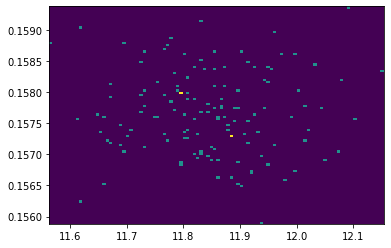

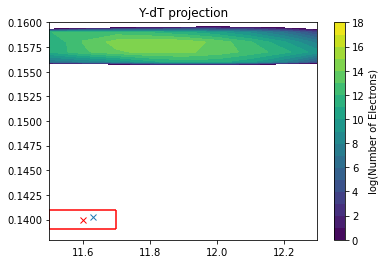

In [ ]:
evtnum = 1

fig = plt.figure()
plt.hist2d(DriftedEvents[evtnum]['y'], DriftedEvents[evtnum]['dt'], 
           range=((min(DriftedEvents[evtnum]['y']),max(DriftedEvents[evtnum]['y'])),
                  (min(DriftedEvents[evtnum]['dt']),max(DriftedEvents[evtnum]['dt']))), bins=(100,100));

fig = plt.figure()
ax = fig.add_subplot(111)
ct = ax.contourf(ReadoutGrids[evtnum][1][0,:,:],ReadoutGrids[evtnum][2][0,:,:], 
     np.log(np.sum(ReadoutEvents[evtnum], axis=0)), levels=np.linspace(0,18,19))
plt.plot(InitVertices[evtnum][1], 
         (InitVertices[evtnum][2])/det.vdrift, 'x')
chy = round((InitVertices[evtnum][1])/det.pitch_y)
chdt = round(((InitVertices[evtnum][2])/det.vdrift)/det.samplerate)
spacingcut = 1
plt.plot(chy*det.pitch_y, 
         chdt*det.samplerate, 'rx')
plt.vlines(np.array([chy-spacingcut,chy+spacingcut])*det.pitch_y, 
           (chdt-spacingcut)*det.samplerate, (chdt+spacingcut)*det.samplerate, 'r')
plt.hlines(np.array([chdt-spacingcut,chdt+spacingcut])*det.samplerate, 
           (chy-spacingcut)*det.pitch_y, (chy+spacingcut)*det.pitch_y, 'r')

plt.title('Y-dT projection')
cb = plt.colorbar(ct, drawedges=False, spacing='proportional', label='log(Number of Electrons)')

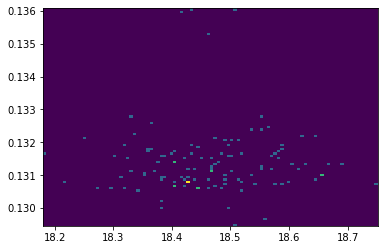

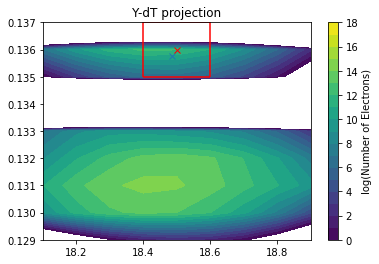

In [ ]:
evtnum = 0

fig = plt.figure()
plt.hist2d(DriftedEvents[evtnum]['y'], DriftedEvents[evtnum]['dt'], 
           range=((min(DriftedEvents[evtnum]['y']),max(DriftedEvents[evtnum]['y'])),
                  (min(DriftedEvents[evtnum]['dt']),max(DriftedEvents[evtnum]['dt']))), bins=(100,100));

fig = plt.figure()
ax = fig.add_subplot(111)
ct = ax.contourf(ReadoutGrids[evtnum][1][0,:,:],ReadoutGrids[evtnum][2][0,:,:], 
     np.log(np.sum(ReadoutEvents[evtnum], axis=0)), levels=np.linspace(0,18,19))
plt.plot(InitVertices[evtnum][1], 
         (InitVertices[evtnum][2])/det.vdrift, 'x')
chy = round((InitVertices[evtnum][1])/det.pitch_y)
chdt = round(((InitVertices[evtnum][2])/det.vdrift)/det.samplerate)
spacingcut = 1
plt.plot(chy*det.pitch_y, 
         chdt*det.samplerate, 'rx')
plt.vlines(np.array([chy-spacingcut,chy+spacingcut])*det.pitch_y, 
           (chdt-spacingcut)*det.samplerate, (chdt+spacingcut)*det.samplerate, 'r')
plt.hlines(np.array([chdt-spacingcut,chdt+spacingcut])*det.samplerate, 
           (chy-spacingcut)*det.pitch_y, (chy+spacingcut)*det.pitch_y, 'r')

plt.title('Y-dT projection')
cb = plt.colorbar(ct, drawedges=False, spacing='proportional', label='log(Number of Electrons)')

In [ ]:
det.samplerate

0.001

In [ ]:
(InitVertices[evtnum][1])/det.pitch_y

184.84551184134165

In [ ]:
round((InitVertices[evtnum][1])/det.pitch_y)*det.pitch_y

18.5

In [ ]:
(InitVertices[evtnum][2]/det.vdrift)/det.samplerate

135.77849312081975

In [ ]:
round((InitVertices[evtnum][2]/det.vdrift)/det.samplerate)*det.samplerate

0.136

Text(0.5, 1.0, 'X-Y projection')

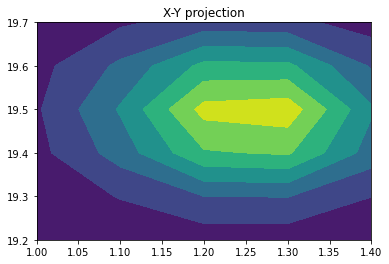

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(ReadoutGrid[0][:,:,0],ReadoutGrid[1][:,:,0], np.sum(ReadoutEvt, axis=2))
plt.title('X-Y projection')